In [ ]:
# Date: 7.12.2023
# Author: Antti Kiviaho
#
# Notebook for associating survival and progression with the Club-region signature

In [44]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

from scripts.utils import load_from_pickle, save_to_pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

import gseapy as gp
import GSVA

import seaborn as sns
sns.set_theme(style='white')


import warnings
warnings.filterwarnings("ignore")



In [39]:
def plot_distribution(df,score_name, thr = 0.5):

    data = df[score_name]
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the histogram with blue bars for values smaller than the median and orange bars for values larger than the median
    n, bins, patches = ax.hist(data, bins=30)

    # Add a vertical line at the median
    ax.axvline(x=data.quantile(thr), color='black', linestyle='--')

    # Set labels and title
    ax.set_xlabel('Enrichment score')
    ax.set_ylabel('Frequency')
    ax.set_title(score_name + ' signature score distribution')

    # Show the plot
    plt.show()


def plot_kaplan_meier(df, score, measure, event, thr = 0.5):
    
    # Split the dataframe into two groups based on the 'Club region' score
    group1 = df[df[score] <= df[score].quantile(thr)]
    group2 = df[df[score] > df[score].quantile(thr)]

    # Create a KaplanMeierFitter object for each group
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()

    # Fit the survival data to the Kaplan-Meier estimator for each group
    kmf1.fit(group1[measure], event_observed=group1[event], label=score + ' low')
    kmf2.fit(group2[measure], event_observed=group2[event], label=score + ' high')

    # Plot the Kaplan-Meier curves for each group
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xlim(0,120)
    kmf1.plot(ax=ax, show_censors=True, ci_show=False)
    kmf2.plot(ax=ax, show_censors=True, ci_show=False)

    # Add labels and title to the plot
    plt.xlabel('Time (months)')
    plt.ylabel('Progression Free Interval (PFI)')



    results = logrank_test(group1[measure], group2[measure], event_observed_A=group1[event], event_observed_B=group2[event])

    # Print the p-value and test statistic
    print("Log-Rank Test p-value: {:.4f}".format(results.p_value))
    print("Log-Rank Test statistic: {:.1f}".format(results.test_statistic))

    plt.title(score + ' GSVA score split by q=' + str(thr) + '\n two-sided log-rank p-value: {:.2e}'.format(results.p_value))

    # Add legend to the plot
    plt.legend()

    # Add 'at risk' counts table to the plot
    add_at_risk_counts(kmf1, kmf2)

    # Display the plot
    plt.show()


def check_top_markers(r,n=20):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231107.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)

    return fishers_test_df[:n]

def check_gene_marker_status(gene):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231107.pkl')

    for r in deg_fishers_res_dict:
        fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
        fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
        if fishers_test_df['gene'].str.contains(gene).any(): 
            print(fishers_test_df[fishers_test_df['gene']==gene])
            print('')

In [68]:



gene_set_df = pd.read_csv('custom_gene_lists_encode_fixed.gmt',sep='\t',header=None, index_col=0).T

gene_sets_of_interest = gene_set_df.columns.tolist()

gene_sets = gene_set_df[gene_sets_of_interest].to_dict('list')

for key, value in gene_sets.items():
    # Remove NaN values from the list
    gene_sets[key] = [x for x in value if pd.notnull(x)]

In [74]:
gene_modules_dict = {
    'Tumor region': check_top_markers('Tumor',100)['gene'].tolist(),
    'Luminal region': check_top_markers('Luminal epithelium',100)['gene'].tolist(),
    'Basal region': check_top_markers('Basal epithelium',100)['gene'].tolist(),
    'Club region': check_top_markers('Intermediate epithelium',100)['gene'].tolist(),
                    }

gene_modules_dict = {**gene_modules_dict,**gene_sets}


df = pd.DataFrame.from_dict(gene_modules_dict,orient='index').reset_index(names='name')
df = df.melt(id_vars='name').sort_values('name').dropna().reset_index(drop=True)
df.columns = ['name','description','member']
df['description'] = 'NA'
gmt_format_df = df.copy()

## TCGA-PRAD

In [6]:
# There is something going wrong here. Either in the scoring or data annotation & plotting. Cannot replicate Sinja's 
# results from the Nature comms paper. 

In [70]:
tcga_sample_sheet = pd.read_csv('bulk_RNAseq/TCGA_PRAD/gdc_sample_sheet.2023-12-07.tsv',sep='\t').set_index('Case ID')

tcga_patient_annot = pd.read_csv('bulk_RNAseq/TCGA_PRAD/TCGA_patient_annotations.csv',index_col=0).set_index('patient_barcode')
tcga_patient_annot = tcga_patient_annot[tcga_patient_annot['type'] == 'PRAD']

tcga_metadata = pd.merge(tcga_sample_sheet,tcga_patient_annot,left_index=True,right_index=True,how='left')
tcga_metadata['PFI'].value_counts()

0.0    451
1.0     92
Name: PFI, dtype: int64

In [71]:
count_type = 'tpm_unstranded'
tcga_df_list = []

for idx in np.arange(len(tcga_metadata)):
    dir = tcga_metadata['File ID'].iloc[idx]
    file_name = tcga_metadata['File Name'].iloc[idx]
    sample = tcga_metadata['Sample ID'].iloc[idx]

    path = 'bulk_RNAseq/TCGA_PRAD/sequencing_reads/'+dir+'/'+file_name

    dat = pd.read_csv(path,sep='\t',index_col=None,skiprows=1)
    dat = dat.drop(index=[0,1,2,3])
    dat = dat[dat['gene_type'] == 'protein_coding'].reset_index(drop=True)
    dat = dat[['gene_name',count_type]].set_index('gene_name')
    dat.columns = [sample]

    tcga_df_list.append(dat)

    if idx %50 ==0:
        print(str(idx)+'/'+str(len(tcga_metadata)))

tcga_counts_dat = pd.concat(tcga_df_list,axis=1)

0/543
50/543
100/543
150/543
200/543
250/543
300/543
350/543
400/543
450/543
500/543


In [89]:
#  Run enrichment using the gseapy gsva method

tcga_enrich_res = gp.gsva(data=tcga_counts_dat,gene_sets=gene_modules_dict,outdir=None)
tcga_enrich_df = tcga_enrich_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

for col in tcga_enrich_df.columns:
    if (col != 'Term') & (col != 'Sample Identifier'):
        
        # Inverse the scores since there is something wrong with replication otherwise
        tcga_enrich_df[col] = tcga_enrich_df[col].astype(float)

final_tcga_data = pd.merge(tcga_enrich_df,tcga_metadata,left_on='Sample Identifier',right_on='Sample ID').set_index('Sample Identifier')


# Transform days to months 
for col in final_tcga_data.columns:
    if '.time' in col:
        final_tcga_data[col] = final_tcga_data[col] / 30        

2023-12-08 15:06:02,731 [WARNING] Found duplicated gene names, values averaged by gene names!


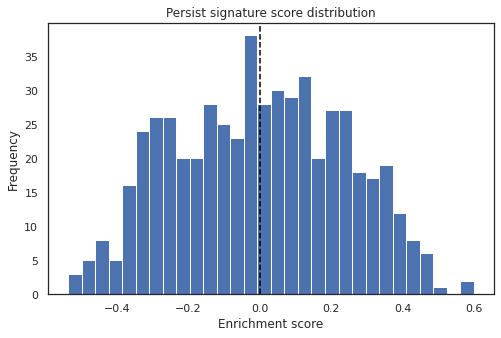

Log-Rank Test p-value: 0.0019
Log-Rank Test statistic: 9.6


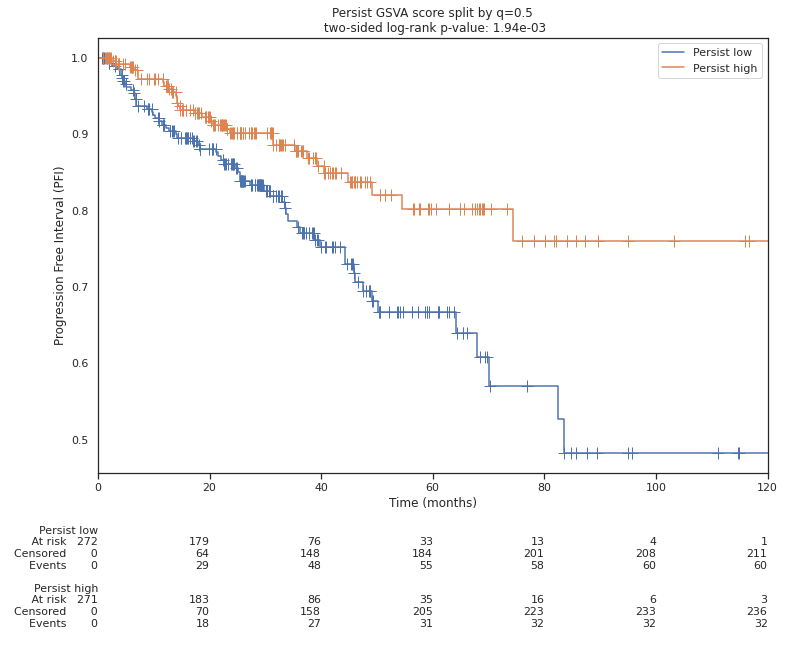

In [92]:
score_n = 'Persist'
q = 0.5

plot_distribution(final_tcga_data,score_n,thr=q)
plot_kaplan_meier(final_tcga_data, score_n, 'PFI.time', 'PFI',thr=q)

In [ ]:
score = 'Club region'

df = final_tcga_data[final_tcga_data['treatment_outcome_first_course'].isin([
    'Complete Remission/Response','Partial Remission/Response','Stable Disease','Progressive Disease'])]

df['treatment_outcome_first_course'] = df['treatment_outcome_first_course'].astype('category').cat.set_categories(['Complete Remission/Response','Partial Remission/Response','Stable Disease','Progressive Disease'])

ax = sns.boxplot(df,y=score,x='treatment_outcome_first_course')
ax.set_xticklabels(ax.get_xticklabels(),rotation=25)
plt.show()

## SU2C Metastatic Prostate Adenocarcinoma (SU2C/PCF Dream Team, PNAS 2019)

In [ ]:
# Download both subsets
dat_polya = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_mrna_seq_fpkm_polya.txt',sep='\t',index_col=0)
dat_capture = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_mrna_seq_fpkm_capture.txt',sep='\t',index_col=0)

In [ ]:
# Download clinical data (patient based)

# Format the dataframe
meta_patient = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_clinical_patient.txt',sep='\t')
meta_patient = meta_patient.drop(index=[0,1,2,3,4]).reset_index(drop=True)
meta_patient.columns = [s.strip('#') for s in meta_patient.columns]

# Discard patient for whom there is no OS data
meta_patient = meta_patient[~(meta_patient['Overall Survival Status'].isna())]
meta_patient['Overall Survival Status'].value_counts()

In [ ]:
# Download sample metadata

# Format the dataframe
meta_sample = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_clinical_sample.txt',sep='\t')
meta_sample = meta_sample.drop(index=[0,1,2,3,4]).reset_index(drop=True)
meta_sample.columns = [s.strip('#') for s in meta_sample.columns]

In [ ]:
# Merge patient clinical and sample metadata
metadata = pd.merge(meta_sample[['Sample Identifier','Patient Identifier']],meta_patient,left_on='Patient Identifier',right_on='Patient Identifier',how='left')
metadata = metadata[~(metadata['Overall Survival Status'].isna())]

### Run scoring

In [ ]:
# Run enrichment of both the the polyA and the 

polya_ssgsea_res = gp.ssgsea(data=dat_polya,gene_sets=gene_modules_dict,sample_norm_method='rank')
polya_ssgsea_df = polya_ssgsea_res.res2d.pivot(index='Term', columns='Name', values='NES').T.reset_index(names='Sample Identifier')

capture_ssgsea_res = gp.ssgsea(data=dat_capture,gene_sets=gene_modules_dict,sample_norm_method='rank')
capture_ssgsea_df = capture_ssgsea_res.res2d.pivot(index='Term', columns='Name', values='NES').T.reset_index(names='Sample Identifier')

In [ ]:
# Merge enrichment results with the metadata
polya_enrichment_res = pd.merge(metadata,polya_ssgsea_df,left_on='Sample Identifier',right_on='Sample Identifier')
capture_enrichment_res = pd.merge(metadata,capture_ssgsea_df,left_on='Sample Identifier',right_on='Sample Identifier')

# Include only samples that don't have polya from the capture set
capture_enrichment_res_non_ovelap = capture_enrichment_res[~(capture_enrichment_res['Sample Identifier'
    ].isin(polya_enrichment_res['Sample Identifier']))]

final_enrichment_dataset = pd.concat([polya_enrichment_res,capture_enrichment_res_non_ovelap],axis=0,ignore_index=True)

### Plot Kaplan Meiers

In [ ]:
score = 'Club region'

sns.set_theme(style='white')

df = final_enrichment_dataset.copy()
df['Overall Survival (Months)'] = df['Overall Survival (Months)'].astype(float)
df['Overall Survival Status'] = pd.Series([s.split(':')[0] for s in df['Overall Survival Status']]).astype('float')

# Assuming your dataframe has the following columns: 'Overall Survival (Months)' for survival time,
# 'Overall Survival Status' for event status, and 'Club region' for the score

# Split the dataframe into two groups based on the 'Club region' score
group1 = df[df[score] <= df[score].quantile(0.5)]
group2 = df[df[score] > df[score].quantile(0.5)]

# Create a KaplanMeierFitter object for each group
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Fit the survival data to the Kaplan-Meier estimator for each group
kmf1.fit(group1['Overall Survival (Months)'], event_observed=group1['Overall Survival Status'], label='Low expression')
kmf2.fit(group2['Overall Survival (Months)'], event_observed=group2['Overall Survival Status'], label='High expression')

# Plot the Kaplan-Meier curves for each group
fig, ax = plt.subplots(figsize=(12,8))
ax = kmf1.plot()
kmf2.plot(ax=ax)

# Add labels and title to the plot
plt.xlabel('Time (months)')
plt.ylabel('Overall survival (OS) probability')
plt.title('Kaplan-Meier split by ' + score + ' ssGSEA score')

# Add legend to the plot
plt.legend()

# Add 'at risk' counts table to the plot
add_at_risk_counts(kmf1, kmf2)

# Display the plot
plt.show()


### Redundant

In [ ]:
#  Run enrichment using seurat method

tcga_counts_ad = ad.AnnData(tcga_counts_dat.T)
tcga_counts_ad.var_names_make_unique()

for mod in gene_modules_dict:
    sc.tl.score_genes(tcga_counts_ad,gene_list= gene_modules_dict[mod],score_name=mod)

tcga_enrich_df = tcga_counts_ad.obs.copy()
tcga_enrich_df['Sample Identifier'] = tcga_counts_ad.obs_names

final_tcga_data = pd.merge(tcga_enrich_df,tcga_metadata,left_on='Sample Identifier',right_on='Sample ID').set_index('Sample Identifier')


# Transform days to months 
for col in final_tcga_data.columns:
    if '.time' in col:
        final_tcga_data[col] = final_tcga_data[col] / 30      